# Distributed haloes analysis
<b>Author</b>: Natalie B. Hogg

We use `lenstronomy` to create an image produced by the so-called "distributed haloes" model, where we have a main lens modelled by an EPL profile, with a large number of NFW haloes along the line-of-sight, both in front of and behind the main lens. We draw the positions of the haloes from a plectrum-shaped volume whose radius is dependent on the number density of haloes and the comoving distances from observer to halo and observer to source. We obtain the number density of the haloes and their masses from a halo mass function computed using `colossus`. We use the multi-plane lensing functionality of `lenstronomy` to place the haloes along the line-of-sight.

We create a mock image that would be observed in this situation, and attempt to fit it with a model which includes an EPL main lens plus line-of-sight shear. We aim to show that the MCMC can correctly recover the predicted LOS shears. We find that a number of haloes break the tidal approximation and induce a flexion-like residual in the reconstructed image. With these beyond-tidal haloes removed from the population, the LOS shears are recovered perfectly.

**This notebook loads the saved haloes and analyses the image produced**.

## Contents <a name="contents"></a>
1. [Set up](#setup)
2. [Main lens](#main)
3. [Total haloes](#t)
 1. [Source](#ts)
 2. [Image](#ti)
 3. [MCMC](#tm)
 4. [Contour plot](#tc)
4. [Surviving haloes](#s)
 1. [Source](#ss)
 2. [Image](#si)
 3. [MCMC](#sm)
 4. [Contour plot](#sc)

## Set up <a name="setup"></a>

### Import packages

In [1]:
# computation
import numpy as np
import pandas as pd
from multiprocessing import cpu_count
ncpu = cpu_count()

# plotting
import seaborn as sns
import cmasher as cmr
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rc, rcParams, rcParamsDefault

# cosmology
from colossus.cosmology import cosmology as colcos
from colossus.lss import mass_function
from chainconsumer import ChainConsumer
from astropy.table import Table

# monitoring
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# show figures inline
%matplotlib inline

outpath  = r'/home/natalie/Documents/Projects/los_effects/figures/distributed_haloes/' 

job_name = 'million'

# maintain same settings as the population was generated with
theta_E  = 1.0
z_lens   = 1.2
z_source = 2.5

### Import `lenstronomy` packages

In [2]:
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.SimulationAPI.ObservationConfig.HST import HST
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot

### Useful functions

In [3]:
def show_palette(colour):
    # function for displaying colour palettes
    sns.set_style('whitegrid')
    hex2rgb = []
    for k in colour:
        h = k.lstrip('#')
        hex2rgb.append(tuple(int(h[i:i + 2], 16) / 255.0 for i in (0, 2, 4)))
    return sns.palplot(hex2rgb)

def ellipticity(phi, q):
    # transforms orientation angle phi and aspect ratio q into complex ellipticity modulii e1, e2
    e1 = (1 - q)/(1 + q)*np.cos(2*phi)
    e2 = (1 - q)/(1 + q)*np.sin(2*phi)
    return e1, e2

def distance_conversion(distance, conversion_type):
    # converts a distance in Mpc to Gpc, kpc, pc or m
    # careful! it doesn't sanity check your input
    if conversion_type == 'to Gpc':
        new_distance = distance/(10**3)
    elif conversion_type == 'to kpc':
        new_distance = distance*(10**3)
    elif conversion_type == 'to pc':
        new_distance = distance*(10**6)
    elif conversion_type == 'to m':
        new_distance = distance*(3.086*10**22)
    else:
        print('Unknown conversion type')
    return new_distance

def angle_conversion(angle, conversion_type):
    # converts an angle in arcsec to rad or rad to arcsec
    # careful! it doesn't sanity check your input
    conversion_factor = np.pi/(180*3600)
    if conversion_type == 'to arcsecs':
        new_angle = angle/conversion_factor
    elif conversion_type == 'to radians':
        new_angle = angle*conversion_factor
    else:
        print('Unknown conversion type')
    return new_angle

### Global plotting and display settings

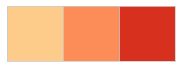

In [4]:
# contour plot colours
# thanks to colorbrewer for these palettes! https://colorbrewer2.org
green        = ['#a6dba0','#5aae61','#1b7837']
purple       = ['#c2a5cf', '#9970ab', '#762a83']
analogous    = ['#a0c3db', '#dbb7a0']
warm         = ['#fdcc8a', '#fc8d59', '#d7301f']
cool         = ['#41b6c4', '#2c7fb8', '#253494']

# have a look at a palette for example
show_palette(warm)

# set the seaborn style
sns.set_style('ticks')

# use TeX for plot labels
rc('text', usetex=True)
rc('font', family='serif')
matplotlib.rcParams.update({'font.size': 18})

### Global MCMC settings

In [5]:
walker_ratio = 10     # number of walkers per parameter
n_burn       = 500   # number of burn-in steps
n_run        = 500   # number of sampling steps
sigma_scale  = 1.0   # multiplies the initial spread of each parameter
param_sigma  = 0.001 # expected standard deviation of sampled shears
param_min    = -0.1  # lower bound of prior on sampled shears
param_max    = 0.1   # upper bound of prior on sampled shears

## Create main lens: `EPL` <a name="main"></a>

[Back to contents](#contents)

In [6]:
# note the lens position is added later as it needs to be corrected using the alpha_od from the shear data

gamma_epl = 2.6 # slope of power law

# set the ellipticity
lens_orientation_angle = np.random.uniform(0.0, 2*np.pi) # direction of ellipticity relative to the line of sight
lens_aspect_ratio      = np.random.uniform(0.8, 1.0) # ratio of semi-major axis to semi-minor axis of the ellipse (1 -> circle)
e1_epl, e2_epl    = ellipticity(lens_orientation_angle, lens_aspect_ratio)

## Load halo and shear data

In [7]:
total_haloes_fits = Table.read(outpath + 'total_haloes_dataframe_' + job_name + '.fits')
total_haloes_dataframe = total_haloes_fits.to_pandas()

# total_haloes_dataframe = pd.read_csv(outpath + 'total_haloes_dataframe_' + job_name + '.csv')

total_halo_number = len(total_haloes_dataframe)

total_halo_redshift_list = total_haloes_dataframe['z'].to_list()

# kwargs_total_nfw = total_haloes_dataframe[['Rs', 'alpha_Rs', 'center_x', 'center_y', 'e1', 'e2']].to_dict('records')
kwargs_total_nfw = total_haloes_dataframe[['Rs', 'alpha_Rs', 'center_x', 'center_y']].to_dict('records')

In [8]:
surviving_haloes_fits = Table.read(outpath + 'surviving_haloes_dataframe_' + job_name + '.fits')
surviving_haloes_dataframe = surviving_haloes_fits.to_pandas()

# surviving_haloes_dataframe = pd.read_csv(outpath + 'surviving_haloes_dataframe_' + job_name + '.csv')

surviving_halo_number = len(surviving_haloes_dataframe)

surviving_halo_redshift_list = surviving_haloes_dataframe['z'].to_list()

kwargs_surviving_nfw = surviving_haloes_dataframe[['Rs', 'alpha_Rs', 'center_x', 'center_y']].to_dict('records')

In [9]:
total_shears_dataframe = pd.read_csv(outpath + 'total_shears_dataframe_' + job_name + '.csv')
surviving_shears_dataframe = pd.read_csv(outpath + 'surviving_shears_dataframe_' + job_name + '.csv')

 ## Total haloes case<a name="t"></a>


 ### Source <a name="ts"></a>
 The source offset correction is different for the two cases, so we have to instantiate two different sources. They have some common parameters though.
 
 [Back to contents](#contents)

In [10]:
source_magnitude = 24.0
source_R_sersic = 0.03
source_n_sersic = 1.0

source_orientation_angle = np.random.uniform(0.0, 2*np.pi) 
source_aspect_ratio      = np.random.uniform(0.8, 1.0) 
source_e1, source_e2 = ellipticity(source_orientation_angle, source_aspect_ratio)

In [11]:
# Sersic, Sersic, burning bright, in the redshifts of the night
# what immortal hand or eye could frame thy fearful symmetry?

total_source_model_list = ['SERSIC_ELLIPSE']

total_kwargs_sersic = {'magnitude': source_magnitude, 
                       'R_sersic': source_R_sersic, 
                       'n_sersic': source_n_sersic,
                       'e1': source_e1, 
                       'e2': source_e2,
                       'center_x': -total_shears_dataframe['alpha1_os'].values[0], 
                       'center_y': -total_shears_dataframe['alpha2_os'].values[0]}

total_kwargs_source = [total_kwargs_sersic]

### Image <a name="ti"></a>

[Back to contents](#contents)

In [12]:
total_lens_mock_list = ['EPL'] + ['NFW']*total_halo_number

total_redshift_list = [z_lens] + total_halo_redshift_list 

total_kwargs_epl = {'theta_E': theta_E,
                    'gamma': gamma_epl,
                    'center_x': -total_shears_dataframe['alpha1_od'].values[0],
                    'center_y': -total_shears_dataframe['alpha2_od'].values[0],
                    'e1': e1_epl,
                    'e2': e2_epl}

total_kwargs_lens = [total_kwargs_epl]

print('\n Appending the haloes kwargs to the kwargs_lens')
for i in tqdm(range(len(total_halo_redshift_list))):
    total_kwargs_lens.append(kwargs_total_nfw[i])
    
kwargs_model = {'lens_model_list': total_lens_mock_list,
                'lens_redshift_list': total_redshift_list, # the presence of the list tells SimAPI to use multiplane
                'z_source': z_source,
                'source_light_model_list': total_source_model_list}


 Appending the haloes kwargs to the kwargs_lens


  0%|          | 0/1265493 [00:00<?, ?it/s]

In [13]:
# get the telescope settings for HST
psf = 'GAUSSIAN'
band = HST(band='WFC3_F160W', psf_type=psf) # this chooses the specific camera and filter of HST
kwargs_band = band.kwargs_single_band() # we are only considering a single band (i.e. a single wavelength/filter)
pixel_size = band.camera['pixel_scale'] # in arcsec
kwargs_psf = {'psf_type': psf,
              'fwhm': kwargs_band['seeing'],
              'pixel_size': pixel_size,
              'truncation': 3}

# define the numerics
kwargs_numerics = {'supersampling_factor': 1,
                   'supersampling_convolution': False}

# call the simulation API class
sim = SimAPI(numpix = 49, # number of pixels we want in our image
             kwargs_single_band = kwargs_band, # give the SimAPI class the keyword arguments for HST that we got above
             kwargs_model = kwargs_model)

kwargs_data = sim.kwargs_data

In [14]:
# convert magnitudes into amplitudes
# we don't care about lens light or the point source
ll, total_kwargs_source, ps = sim.magnitude2amplitude(kwargs_source_mag = total_kwargs_source)

# now use the SimAPI class to generate a noisy image in one step
imSim = sim.image_model_class(kwargs_numerics)

total_image = imSim.image(kwargs_lens = total_kwargs_lens,
                          kwargs_source = total_kwargs_source)

total_image_noisy = total_image + sim.noise_for_model(model = total_image)

kwargs_data['image_data'] = total_image_noisy

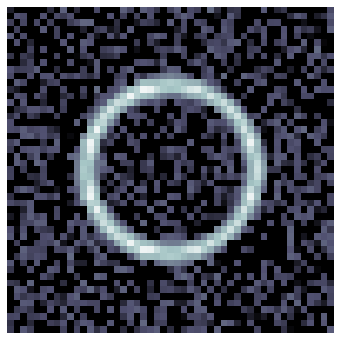

In [15]:
# plot the image
cmap_string = 'bone'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 1

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

total_im = ax.matshow(np.log10(total_image_noisy), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[-1, 1, -1, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
ax.axis('off')

# fig.suptitle('Image from {} haloes'.format(total_halo_number))

plt.savefig(outpath + job_name + '_total_image.pdf', dpi=300, bbox_inches='tight')

plt.show()

### MCMC <a name="tm"></a>

If you get an error about the MCMC not being able to find the chains file, you need to manually create a `chains` directory inside the directory you specified for `outpath`.

[Back to contents](#contents)

In [16]:
# total haloes lens model

lens_model_list = ['LOS_MINIMAL', 'EPL']

# initialise the lists of parameters
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

# Line-of-sight parameters
fixed_lens.append({'kappa_od': total_shears_dataframe['kappa_od'].values[0],'omega_od': 0.0,
                  'kappa_los': total_shears_dataframe['kappa_los'].values[0]})

# notice the below params need to be defined in this order
# or you will get a key error when trying to run the MCMC

params = ['gamma1_od', 'gamma2_od', 
          'gamma1_los', 'gamma2_los',
          'omega_los']

kwargs_lens_init.append({'gamma1_od': total_shears_dataframe['gamma1_od'].values[0],
                         'gamma2_od': total_shears_dataframe['gamma2_od'].values[0],
                         'gamma1_los': total_shears_dataframe['gamma1_los'].values[0],
                         'gamma2_los': total_shears_dataframe['gamma2_los'].values[0],
                         'omega_los': 0.0})

kwargs_lens_sigma.append({param: param_sigma for param in params})
kwargs_lower_lens.append({param: param_min for param in params})
kwargs_upper_lens.append({param: param_max for param in params})

# EPL
# we are fitting with LOS so we expect the image to be centred on ZERO!!!
# i.e. source corrections are naturally present in an LOS model!
fixed_lens.append({})

kwargs_lens_init.append({'theta_E': total_kwargs_epl['theta_E'], 
                         'gamma': total_kwargs_epl['gamma'], 
                         'center_x': 0.0, 
                         'center_y': 0.0,
                         'e1': total_kwargs_epl['e1'], 
                         'e2': total_kwargs_epl['e2']})

kwargs_lens_sigma.append({'theta_E': 0.001, 'gamma': 0.01, 
                          'center_x': 0.01, 'center_y': 0.01,
                          'e1': 0.01, 'e2': 0.01})

kwargs_lower_lens.append({'theta_E': 0.01, 'gamma': 0.0, 
                          'center_x': -0.5, 'center_y': -0.5,
                          'e1': -0.5, 'e2': -0.5})

kwargs_upper_lens.append({'theta_E': 10, 'gamma': 4.0, 
                          'center_x': 0.5, 'center_y': 0.5,
                          'e1': 0.5, 'e2': 0.5})


lens_params = [kwargs_lens_init,
               kwargs_lens_sigma,
               fixed_lens,
               kwargs_lower_lens,
               kwargs_upper_lens]

# source

source_model_list = ['SERSIC_ELLIPSE']

fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({})

kwargs_source_init.append({'R_sersic': total_kwargs_sersic['R_sersic'], 
                           'n_sersic': total_kwargs_sersic['n_sersic'], 
                           'center_x': 0.0, 
                           'center_y': 0.0,
                           'e1': total_kwargs_sersic['e1'], 
                           'e2': total_kwargs_sersic['e2']})

kwargs_source_sigma.append({'R_sersic': 0.001, 'n_sersic': 0.001, 
                            'center_x': 0.01, 'center_y': 0.01,
                            'e1': 0.01, 'e2': 0.01})

kwargs_lower_source.append({'R_sersic': 0.001, 'n_sersic': 0.5,
                            'center_x': -0.5, 'center_y': -0.5,
                            'e1': -0.5, 'e2': -0.5})

kwargs_upper_source.append({'R_sersic': 10, 'n_sersic': 10.0,
                            'center_x': 0.5, 'center_y': 0.5,
                            'e1': 0.5, 'e2': 0.5})

source_params = [kwargs_source_init, kwargs_source_sigma,
                 fixed_source, kwargs_lower_source, kwargs_upper_source]

kwargs_params = {'lens_model': lens_params,
                 'source_model': source_params}

In [17]:
# run the MCMC
kwargs_likelihood = {'source_marg': True}

kwargs_model = {'lens_model_list': lens_model_list,
                'source_light_model_list': source_model_list}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {'multi_band_list': multi_band_list,
                     'multi_band_type': 'multi-linear'}

kwargs_constraints = {}

fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, 
                              kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['MCMC',
                        {'n_burn': n_burn, 
                         'n_run': n_run,
                         'walkerRatio': walker_ratio, 
                         'threadCount': ncpu,
                         'sigma_scale': sigma_scale,
                         'backend_filename': outpath + 'chains/' 
                         + job_name + '_total.h5'}]]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

print('Best-fit parameters: {}'.format(kwargs_result))

100%|██████████| 1000/1000 [09:18<00:00,  1.79it/s]

Computing the MCMC...
Number of walkers =  170
Burn-in iterations:  500
Sampling iterations (in current run): 1000
558.5194506645203 time taken for MCMC sampling
Best-fit parameters: {'kwargs_lens': [{'kappa_od': 0.0035954722646184, 'gamma1_od': 0.0013954347922005643, 'gamma2_od': -0.00010373063941283058, 'omega_od': 0.0, 'kappa_los': 0.0131992359167519, 'gamma1_los': -0.002514940562923898, 'gamma2_los': 0.0006273556397535827, 'omega_los': 3.700663998310139e-05}, {'theta_E': 1.0000334752279458, 'gamma': 2.4927032271452183, 'e1': -0.07944927269932402, 'e2': 0.0013569249842973383, 'center_x': 0.0008155926022973428, 'center_y': -0.0005582685630446888}], 'kwargs_source': [{'amp': 1, 'R_sersic': 0.027927882231650356, 'n_sersic': 1.0029485466746675, 'e1': -0.026286684422956313, 'e2': 0.023950838405355848, 'center_x': 0.008680556284374698, 'center_y': 0.000641778643444023}], 'kwargs_lens_light': [], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


In [18]:
print('\nThe predicted LOS terms were:')
print('gamma1_od  = {:.4}'.format(total_shears_dataframe['gamma1_od'].values[0]))
print('gamma2_od  = {:.4}'.format(total_shears_dataframe['gamma2_od'].values[0]))
print('gamma1_los = {:.4}'.format(total_shears_dataframe['gamma1_los'].values[0]))
print('gamma2_los = {:.4}'.format(total_shears_dataframe['gamma2_los'].values[0]))
print('omega_los  = {:.4}'.format(0.0))


print('\nThe fit LOS terms are:')
for i in params:
    print(str(i)+' = {:.4}'.format(kwargs_result['kwargs_lens'][0][i]))


The predicted LOS terms were:
gamma1_od  = -0.0007379
gamma2_od  = -0.0002964
gamma1_los = -0.0009723
gamma2_los = 0.001202
omega_los  = 0.0

The fit LOS terms are:
gamma1_od = 0.001395
gamma2_od = -0.0001037
gamma1_los = -0.002515
gamma2_los = 0.0006274
omega_los = 3.701e-05


-0.9866588859215645 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.9866588859215647


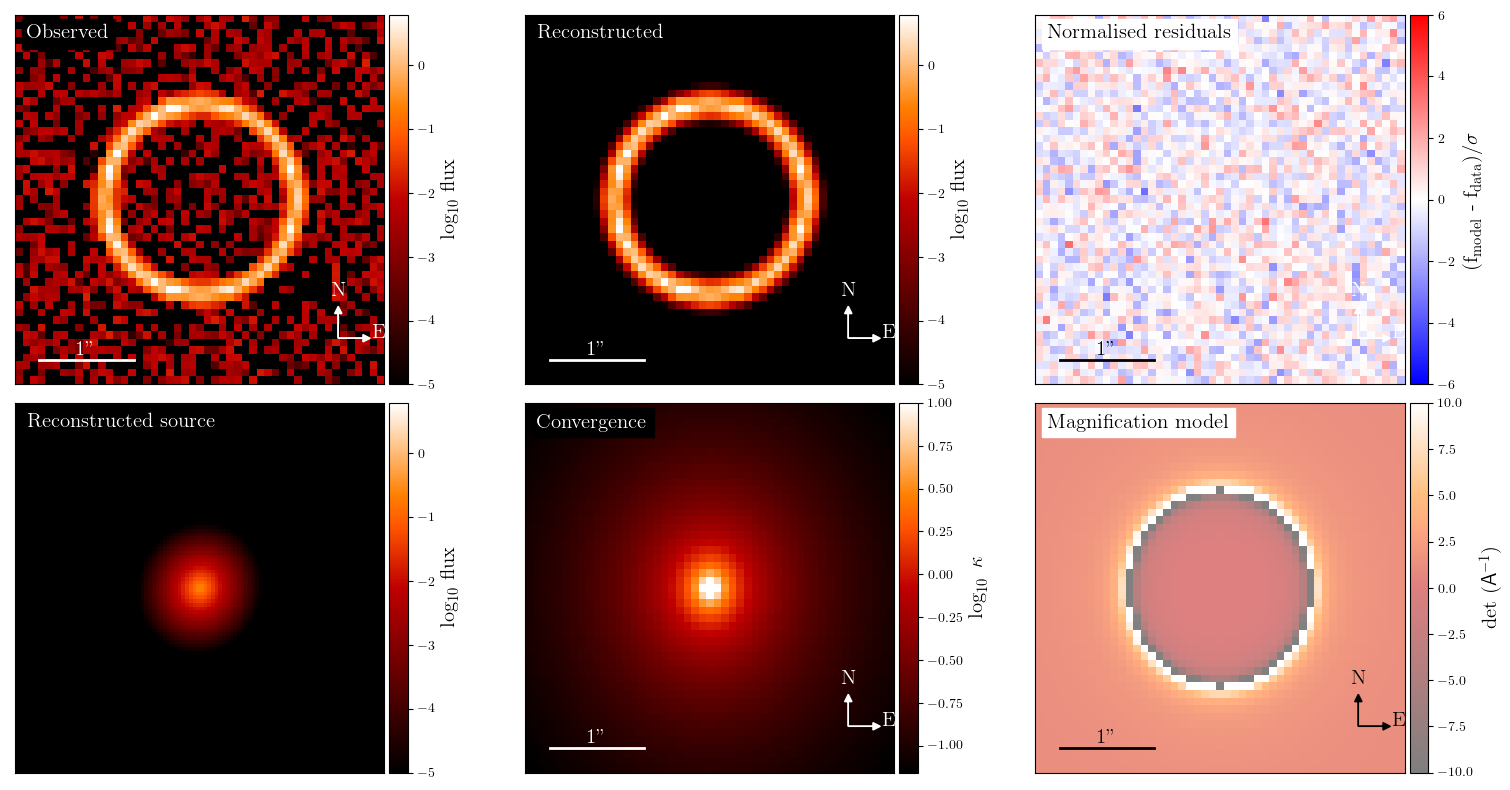

In [38]:
# look at the reconstructed image
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string='gist_heat')
    
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], text="Normalised residuals")#, v_min=-10, v_max=10, cmap='cmr.prinsenvlag')
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)

plt.savefig(outpath + job_name + '_total_reconstruction.pdf', dpi=300, bbox_inches='tight')

plt.show()

-0.9866588859215645 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.9866588859215647


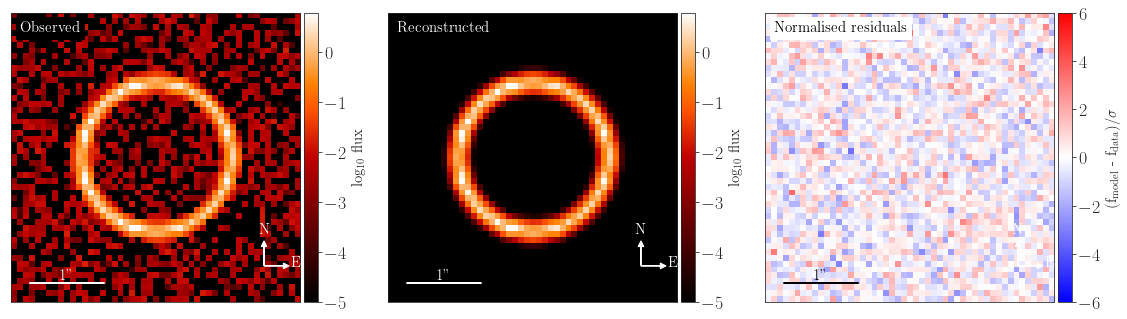

In [20]:
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string='gist_heat')
    
f, axes = plt.subplots(1, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0])
modelPlot.model_plot(ax=axes[1])
modelPlot.normalized_residual_plot(ax=axes[2], text="Normalised residuals")#, v_min=-10, v_max=10, cmap='cmr.prinsenvlag')
f.tight_layout()
# f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)

plt.savefig(outpath + job_name + '_total_reconstruction_top.pdf', dpi=300, bbox_inches='tight')

plt.show()

Number of non-linear parameters in the MCMC process: 17
Parameters in order: ['gamma1_od_lens0', 'gamma2_od_lens0', 'gamma1_los_lens0', 'gamma2_los_lens0', 'omega_los_lens0', 'theta_E_lens1', 'gamma_lens1', 'e1_lens1', 'e2_lens1', 'center_x_lens1', 'center_y_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0']
Number of evaluations in the MCMC process: 85000


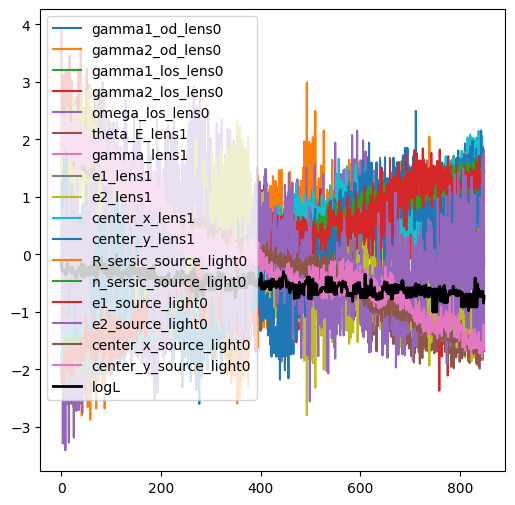

In [21]:
# convergence check
rcParams.update(rcParamsDefault) # reset default font because this plot looks weird otherwise

for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)
    
sampler_type, samples_mcmc_total, param_mcmc, dist_mcmc  = chain_list[0]

print('Number of non-linear parameters in the MCMC process: {}'.format(len(param_mcmc)))
print('Parameters in order: {}'.format(param_mcmc))
print('Number of evaluations in the MCMC process: {}'.format(np.shape(samples_mcmc_total)[0]))

In [22]:
# "if you have a procedure with ten parameters, you probably missed some"

labels = [# LOS
          r'$\gamma^{od}_1$',
          r'$\gamma^{od}_2$',
          r'$\gamma^{\rm LOS}_1$',
          r'$\gamma^{\rm LOS}_2$',
          r'$\omega^{\rm LOS}$',
          # EPL
          r'$\theta_{\rm E}$',
          r'$\gamma_{\rm EPL}$',
          r'$x$',
          r'$y$',
          r'$e_{1, \rm EPL}$',
          r'$e_{2, \rm EPL}$',
          # source
          r'$R_{\rm Sérsic}$',
          r'$n_{\rm Sérsic}$',
          r'$x$',
          r'$y$',
          r'$e_1^{\rm source}$',
          r'$e_2^{\rm source}$']

expected_values = [# LOS
                   total_shears_dataframe['gamma1_od'].values[0],
                   total_shears_dataframe['gamma2_od'].values[0],
                   total_shears_dataframe['gamma1_los'].values[0],
                   total_shears_dataframe['gamma2_los'].values[0],
                   0.0,
                   # EPL
                   total_kwargs_epl['theta_E'],
                   total_kwargs_epl['gamma'],
                   0.0,
                   0.0,
                   total_kwargs_epl['e1'],
                   total_kwargs_epl['e2'],
                   # source
                   total_kwargs_sersic['R_sersic'],
                   total_kwargs_sersic['n_sersic'],
                   0.0,
                   0.0,
                   total_kwargs_sersic['e1'],
                   total_kwargs_sersic['e2']]

n, num_param = np.shape(samples_mcmc_total)

### Contour plot <a name="tc"> </a>
 
 [Back to contents](#contents)

Gelman-Rubin Statistic values for chain Chain 0
$\gamma^{od}_1$: 1.05930 (Failed)
$\gamma^{od}_2$: 1.00143 (Passed)
$\gamma^{\rm LOS}_1$: 1.08541 (Failed)
$\gamma^{\rm LOS}_2$: 1.00137 (Passed)
False


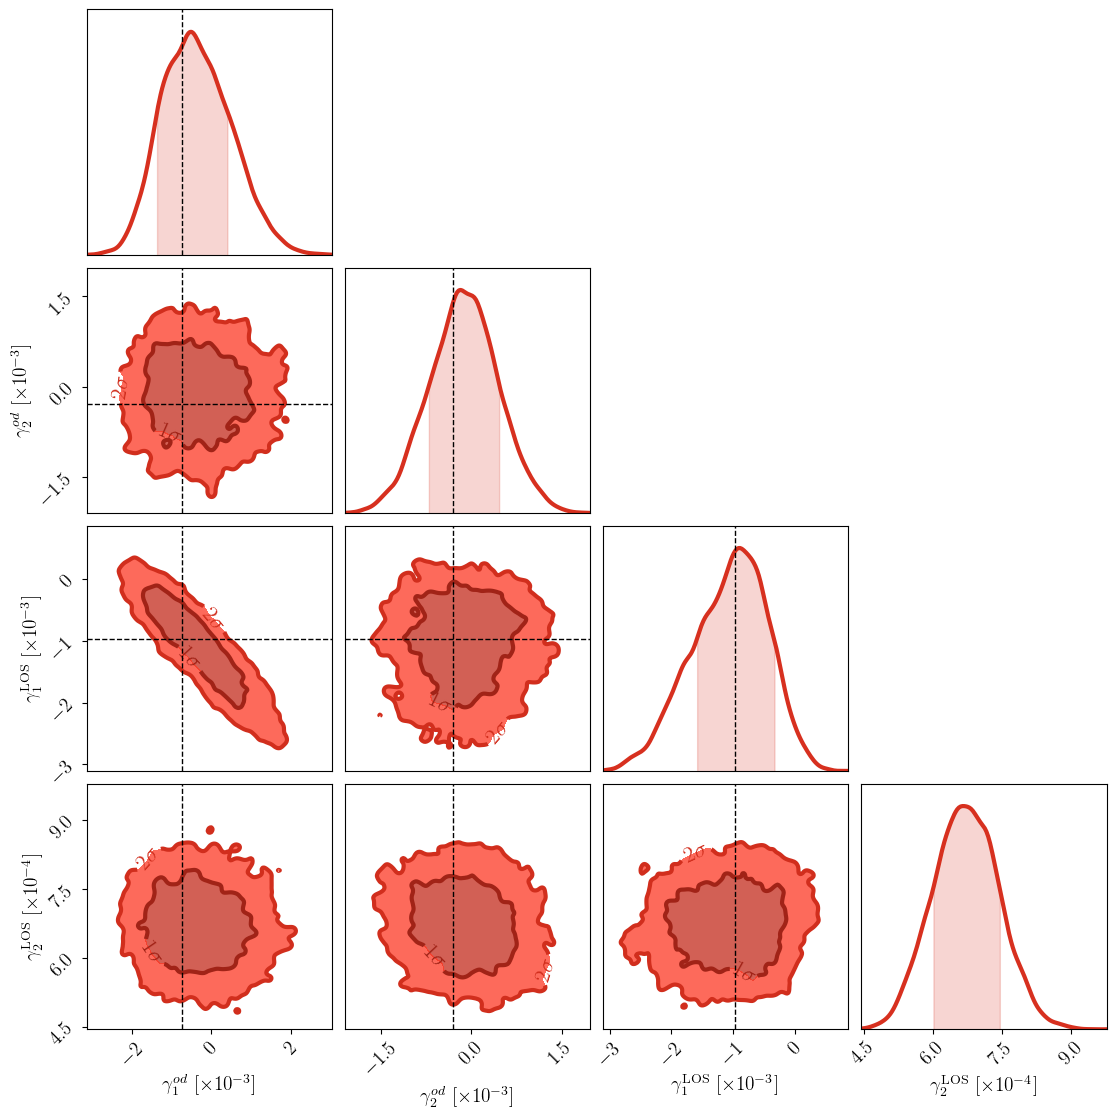

In [23]:
n_walkers = len(param_mcmc)*walker_ratio

c = ChainConsumer()

c.add_chain(samples_mcmc_total[:,0:4], walkers = n_walkers, parameters = labels[0:4])

c.configure(flip = False, summary = False, 
            spacing = 1.0, max_ticks = 4,
            colors = warm[2], shade = True, shade_gradient = 0.4, 
            bar_shade = True, linewidths= [3.0],
            tick_font_size=14, label_font_size=14, 
            usetex = True, serif = True,
            contour_labels = 'sigma', contour_label_font_size = 16)

fig = c.plotter.plot(truth=expected_values[0:4], figsize = (12,12))

fig.patch.set_facecolor('white')

plt.savefig(outpath + job_name + '_total_contours.pdf', dpi=300, bbox_inches='tight')

gelman_rubin_converged = c.diagnostic.gelman_rubin() # not clear if this is robust for emcee chains

print(gelman_rubin_converged)

## Surviving haloes<a name="s"> </a>

### Source <a name = "ss"> </a>

 [Back to contents](#contents)

In [24]:
surviving_source_model_list = ['SERSIC_ELLIPSE']

surviving_kwargs_sersic = {'magnitude': source_magnitude, 
                           'R_sersic': source_R_sersic, 
                           'n_sersic': source_n_sersic,
                           'e1': source_e1, 
                           'e2': source_e2,
                           'center_x': -surviving_shears_dataframe['alpha1_os'].values[0], 
                           'center_y': -surviving_shears_dataframe['alpha2_os'].values[0]}

surviving_kwargs_source = [surviving_kwargs_sersic]

In [25]:
surviving_lens_mock_list = ['EPL'] + ['NFW']*surviving_halo_number

surviving_redshift_list = [z_lens] + surviving_halo_redshift_list 

surviving_kwargs_epl = {'theta_E': theta_E,
                        'gamma': gamma_epl,
                        'center_x': -surviving_shears_dataframe['alpha1_od'].values[0],
                        'center_y': -surviving_shears_dataframe['alpha2_od'].values[0],
                        'e1': e1_epl,
                        'e2': e2_epl}

surviving_kwargs_lens = [surviving_kwargs_epl]

print('\n Appending the haloes kwargs to the kwargs_lens')
for i in tqdm(range(len(surviving_halo_redshift_list))):
    surviving_kwargs_lens.append(kwargs_surviving_nfw[i])
    
        
kwargs_surviving_model = {'lens_model_list': surviving_lens_mock_list,
                          'lens_redshift_list': surviving_redshift_list,
                          'z_source': z_source,
                          'source_light_model_list': surviving_source_model_list}


 Appending the haloes kwargs to the kwargs_lens


  0%|          | 0/1264505 [00:00<?, ?it/s]

### Image<a name = "si"> </a>

 [Back to contents](#contents)

In [26]:
# call the simulation API class
sim_sur = SimAPI(numpix = 49, # number of pixels we want in our image
             kwargs_single_band = kwargs_band, # give the SimAPI class the keyword arguments for HST that we got above
             kwargs_model = kwargs_surviving_model)

kwargs_data_sur = sim_sur.kwargs_data

ll, surviving_kwargs_source, ps = sim_sur.magnitude2amplitude(kwargs_source_mag=surviving_kwargs_source)

imSim_sur = sim_sur.image_model_class(kwargs_numerics)

surviving_image = imSim_sur.image(kwargs_lens = surviving_kwargs_lens,
                              kwargs_source = surviving_kwargs_source)

surviving_image_noisy = surviving_image + sim_sur.noise_for_model(model=surviving_image)

kwargs_data_sur['image_data'] = surviving_image_noisy

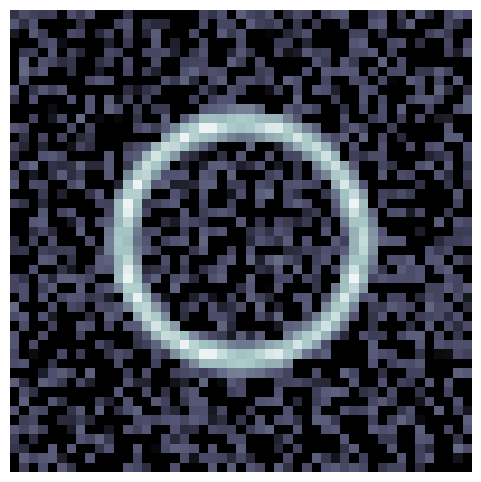

In [27]:
cmap_string = 'bone'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 1

fig, ax = plt.subplots(1, 1, figsize=(6,6))

total_im = ax.matshow(np.log10(surviving_image_noisy), origin='lower', 
                      vmin=v_min, vmax=v_max, cmap=cmap, extent=[-1, 1, -1, 1])

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
ax.axis('off')

# fig.suptitle('Image from {} haloes'.format(surviving_halo_number))

plt.savefig(outpath + job_name + '_surviving_image.pdf', dpi=300, bbox_inches='tight')

plt.show()

### MCMC<a name = "sm"> </a>

 [Back to contents](#contents)

In [28]:
# surviving haloes lens model

lens_model_list = ['LOS_MINIMAL', 'EPL']

fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

# LOS
fixed_lens.append({'kappa_od': surviving_shears_dataframe['kappa_od'].values[0],'omega_od': 0.0,
                  'kappa_los': surviving_shears_dataframe['kappa_los'].values[0]})

params = ['gamma1_od', 'gamma2_od', 
          'gamma1_los', 'gamma2_los',
          'omega_los']

kwargs_lens_init.append({'gamma1_od': surviving_shears_dataframe['gamma1_od'].values[0],
                         'gamma2_od': surviving_shears_dataframe['gamma2_od'].values[0],
                         'gamma1_los': surviving_shears_dataframe['gamma1_los'].values[0],
                         'gamma2_los': surviving_shears_dataframe['gamma2_los'].values[0],
                         'omega_los': 0.0})

kwargs_lens_sigma.append({param: param_sigma for param in params})
kwargs_lower_lens.append({param: param_min for param in params})
kwargs_upper_lens.append({param: param_max for param in params})

# EPL
fixed_lens.append({})

kwargs_lens_init.append({'theta_E': surviving_kwargs_epl['theta_E'], 
                         'gamma': surviving_kwargs_epl['gamma'], 
                         'center_x': 0.0, 
                         'center_y': 0.0,
                         'e1': surviving_kwargs_epl['e1'], 
                         'e2': surviving_kwargs_epl['e2']})

kwargs_lens_sigma.append({'theta_E': 0.001, 'gamma': 0.01, 
                          'center_x': 0.01, 'center_y': 0.01,
                          'e1': 0.01, 'e2': 0.01})

kwargs_lower_lens.append({'theta_E': 0.01, 'gamma': 0.0, 
                          'center_x': -0.5, 'center_y': -0.5,
                          'e1': -0.5, 'e2': -0.5})

kwargs_upper_lens.append({'theta_E': 10, 'gamma': 4.0, 
                          'center_x': 0.5, 'center_y': 0.5,
                          'e1': 0.5, 'e2': 0.5})


lens_params = [kwargs_lens_init,
               kwargs_lens_sigma,
               fixed_lens,
               kwargs_lower_lens,
               kwargs_upper_lens]

# source

source_model_list = ['SERSIC_ELLIPSE']

fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({})

kwargs_source_init.append({'R_sersic': surviving_kwargs_sersic['R_sersic'], 
                           'n_sersic': surviving_kwargs_sersic['n_sersic'], 
                           'center_x': 0.0, 
                           'center_y': 0.0,
                           'e1': surviving_kwargs_sersic['e1'], 
                           'e2': surviving_kwargs_sersic['e2']})

kwargs_source_sigma.append({'R_sersic': 0.001, 'n_sersic': 0.001, 
                            'center_x': 0.01, 'center_y': 0.01,
                            'e1': 0.01, 'e2': 0.01})

kwargs_lower_source.append({'R_sersic': 0.001, 'n_sersic': 0.5,
                            'center_x': -0.5, 'center_y': -0.5,
                            'e1': -0.5, 'e2': -0.5})

kwargs_upper_source.append({'R_sersic': 10, 'n_sersic': 10.0,
                            'center_x': 0.5, 'center_y': 0.5,
                            'e1': 0.5, 'e2': 0.5})

source_params = [kwargs_source_init, kwargs_source_sigma,
                 fixed_source, kwargs_lower_source, kwargs_upper_source]

kwargs_params_sur = {'lens_model': lens_params,
                 'source_model': source_params}

In [31]:
# run the MCMC
kwargs_likelihood = {'source_marg': True}

kwargs_model_sur = {'lens_model_list': lens_model_list,
                    'source_light_model_list': source_model_list}

multi_band_list_sur = [[kwargs_data_sur, kwargs_psf, kwargs_numerics]]

kwargs_data_joint_sur = {'multi_band_list': multi_band_list_sur,
                     'multi_band_type': 'multi-linear'}

kwargs_constraints = {}

fitting_seq_sur = FittingSequence(kwargs_data_joint_sur, kwargs_model_sur, kwargs_constraints, 
                              kwargs_likelihood, kwargs_params_sur)

fitting_kwargs_list = [['MCMC',
                        {'n_burn': n_burn, 
                         'n_run': n_run,
                         'walkerRatio': walker_ratio,
                         'threadCount': ncpu,
                         'sigma_scale': sigma_scale,
                         'backend_filename': outpath + 'chains/' 
                         + job_name + '_surviving.h5'}]]

chain_list_sur = fitting_seq_sur.fit_sequence(fitting_kwargs_list)
kwargs_result_sur = fitting_seq_sur.best_fit()

print('Best fit parameters: {}'.format(kwargs_result_sur))

INFO:lenstronomy.Sampling.Pool.pool:Running with SerialPool


100%|██████████| 1000/1000 [14:25<00:00,  1.16it/s]

Computing the MCMC...
Number of walkers =  170
Burn-in iterations:  500
Sampling iterations (in current run): 1000
865.8131303787231 time taken for MCMC sampling
Best fit parameters: {'kwargs_lens': [{'kappa_od': 0.0030807401131348, 'gamma1_od': 0.000555276035901489, 'gamma2_od': -0.00047616961052898157, 'omega_od': 0.0, 'kappa_los': 0.0110063408043548, 'gamma1_los': -0.0018848495526374036, 'gamma2_los': 0.00020027362537320095, 'omega_los': -6.9600122079486695e-06}, {'theta_E': 1.0000272682683495, 'gamma': 2.5615594547246694, 'e1': -0.08529391964515795, 'e2': 0.004380993866746337, 'center_x': 0.000584910784563078, 'center_y': -0.00041066050700722866}], 'kwargs_source': [{'amp': 1, 'R_sersic': 0.029344435112474244, 'n_sersic': 1.0053395841234785, 'e1': -0.024606917206855095, 'e2': 0.021311010085770712, 'center_x': 0.0073482234227277, 'center_y': 0.00013693660532480443}], 'kwargs_lens_light': [], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


In [32]:
print('\nThe predicted LOS terms were:')
print('gamma1_od  = {:.4}'.format(surviving_shears_dataframe['gamma1_od'].values[0]))
print('gamma2_od  = {:.4}'.format(surviving_shears_dataframe['gamma2_od'].values[0]))
print('gamma1_los = {:.4}'.format(surviving_shears_dataframe['gamma1_los'].values[0]))
print('gamma2_los = {:.4}'.format(surviving_shears_dataframe['gamma2_los'].values[0]))
print('omega_los  = {:.4}'.format(0.0))


print('\nThe fit LOS terms are:')
for i in params:
    print(str(i)+' = {:.4}'.format(kwargs_result_sur['kwargs_lens'][0][i]))


The predicted LOS terms were:
gamma1_od  = -0.0007631
gamma2_od  = -0.0003199
gamma1_los = -0.001176
gamma2_los = 0.0001807
omega_los  = 0.0

The fit LOS terms are:
gamma1_od = 0.0005553
gamma2_od = -0.0004762
gamma1_los = -0.001885
gamma2_los = 0.0002003
omega_los = -6.96e-06


-0.9995631713537344 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.9995631713537344


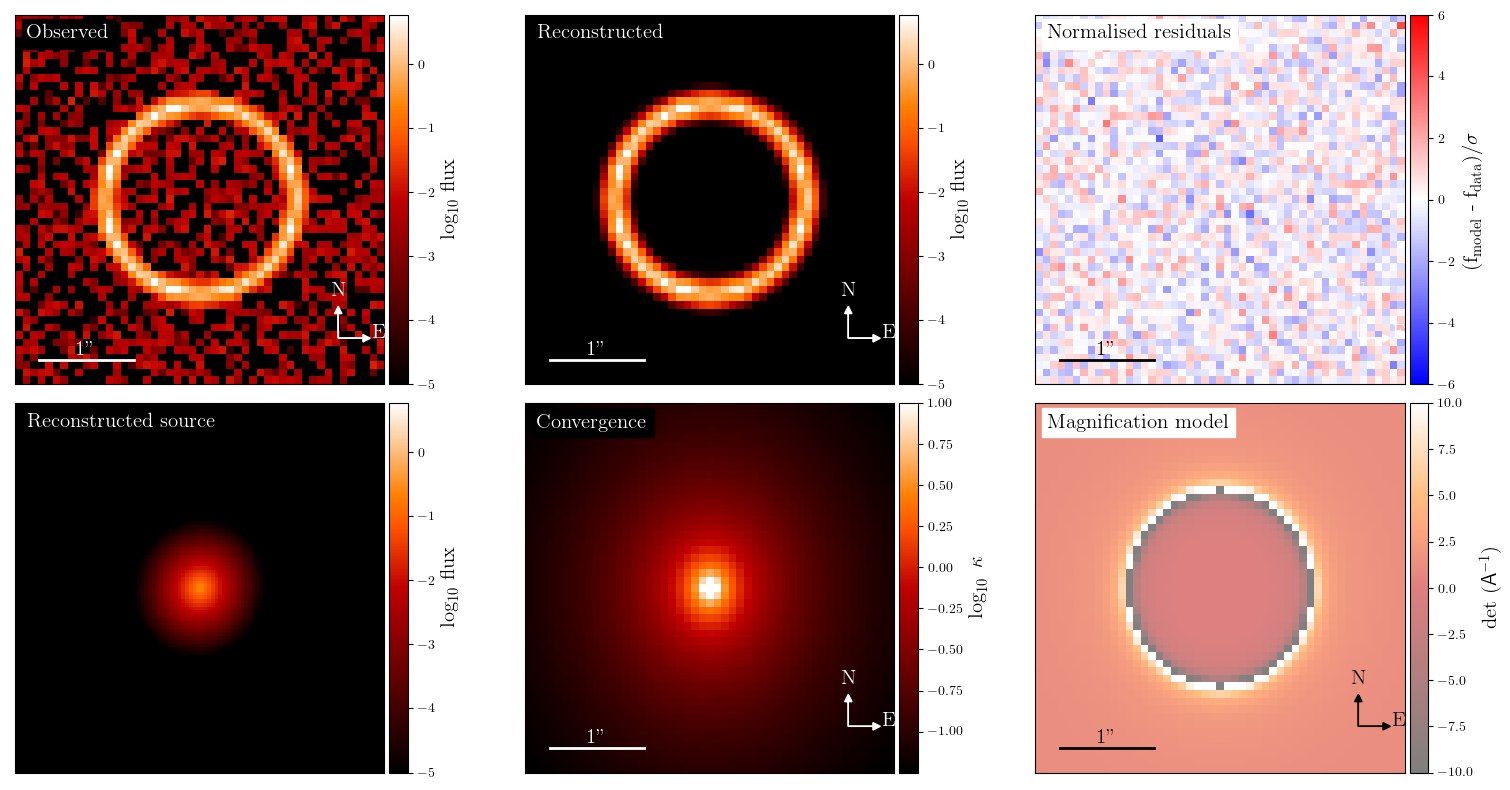

In [33]:
modelPlot_sur = ModelPlot(multi_band_list_sur, kwargs_model_sur, kwargs_result_sur, arrow_size=0.02, cmap_string='gist_heat')
    
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot_sur.data_plot(ax=axes[0,0])
modelPlot_sur.model_plot(ax=axes[0,1])
modelPlot_sur.normalized_residual_plot(ax=axes[0,2], text='Normalised residuals',v_min=-6, v_max=6)
modelPlot_sur.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot_sur.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot_sur.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)

plt.savefig(outpath+ job_name + '_surviving_reconstruction.pdf', dpi=300, bbox_inches='tight')

plt.show()

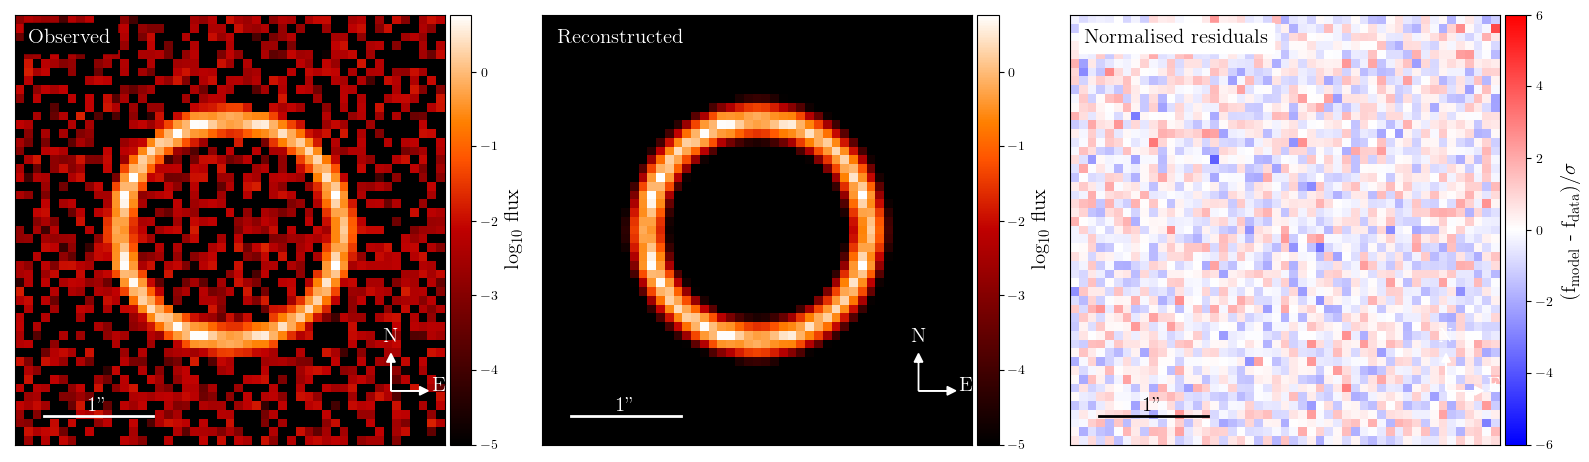

In [34]:
f, axes = plt.subplots(1, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot_sur.data_plot(ax=axes[0])
modelPlot_sur.model_plot(ax=axes[1])
modelPlot_sur.normalized_residual_plot(ax=axes[2], text="Normalised residuals")#, v_min=-10, v_max=10, cmap='cmr.prinsenvlag')
f.tight_layout()
# f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)

plt.savefig(outpath + job_name + '_surviving_reconstruction_top.pdf', dpi=300, bbox_inches='tight')

plt.show()

Number of non-linear parameters in the MCMC process: 17
Parameters in order: ['gamma1_od_lens0', 'gamma2_od_lens0', 'gamma1_los_lens0', 'gamma2_los_lens0', 'omega_los_lens0', 'theta_E_lens1', 'gamma_lens1', 'e1_lens1', 'e2_lens1', 'center_x_lens1', 'center_y_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0']
Number of evaluations in the MCMC process: 85000


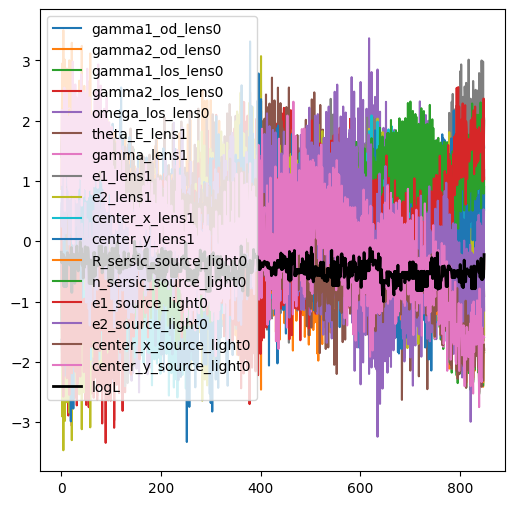

In [35]:
rcParams.update(rcParamsDefault) 

for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list_sur, i)
    
sampler_type, samples_mcmc_sur, param_mcmc_sur, dist_mcmc  = chain_list_sur[0]

print('Number of non-linear parameters in the MCMC process: {}'.format(len(param_mcmc_sur)))
print('Parameters in order: {}'.format(param_mcmc_sur))
print('Number of evaluations in the MCMC process: {}'.format(np.shape(samples_mcmc_sur)[0]))

In [36]:
labels_sur = [# LOS
          r'$\gamma^{od}_1$',
          r'$\gamma^{od}_2$',
          r'$\gamma^{\rm LOS}_1$',
          r'$\gamma^{\rm LOS}_2$',
          r'$\omega^{\rm LOS}$',
          # EPL
          r'$\theta_{\rm E}$',
          r'$\gamma_{\rm EPL}$',
          r'$x$',
          r'$y$',
          r'$e_{1, \rm EPL}$',
          r'$e_{2, \rm EPL}$',
          # source
          r'$R_{\rm Sersic}$',
          r'$n_{\rm Sersic}$',
          r'$x$',
          r'$y$',
          r'$e_1^{\rm source}$',
          r'$e_2^{\rm source}$']

expected_values_sur = [# LOS
                   surviving_shears_dataframe['gamma1_od'].values[0],
                   surviving_shears_dataframe['gamma2_od'].values[0],
                   surviving_shears_dataframe['gamma1_los'].values[0],
                   surviving_shears_dataframe['gamma2_los'].values[0],
                   0.0,
                   # EPL
                   surviving_kwargs_epl['theta_E'],
                   surviving_kwargs_epl['gamma'],
                   0.0,
                   0.0,
                   surviving_kwargs_epl['e1'],
                   surviving_kwargs_epl['e2'],
                   # source
                   surviving_kwargs_sersic['R_sersic'],
                   surviving_kwargs_sersic['n_sersic'],
                   0.0,
                   0.0,
                   surviving_kwargs_sersic['e1'],
                   surviving_kwargs_sersic['e2']]

n, num_param = np.shape(samples_mcmc_sur)

### Contour plot <a name = "sc"> </a>

 [Back to contents](#contents)

Gelman-Rubin Statistic values for chain Chain 0
$\gamma^{od}_1$: 1.00867 (Passed)
$\gamma^{od}_2$: 1.00050 (Passed)
$\gamma^{\rm LOS}_1$: 1.00984 (Passed)
$\gamma^{\rm LOS}_2$: 1.00161 (Passed)
True


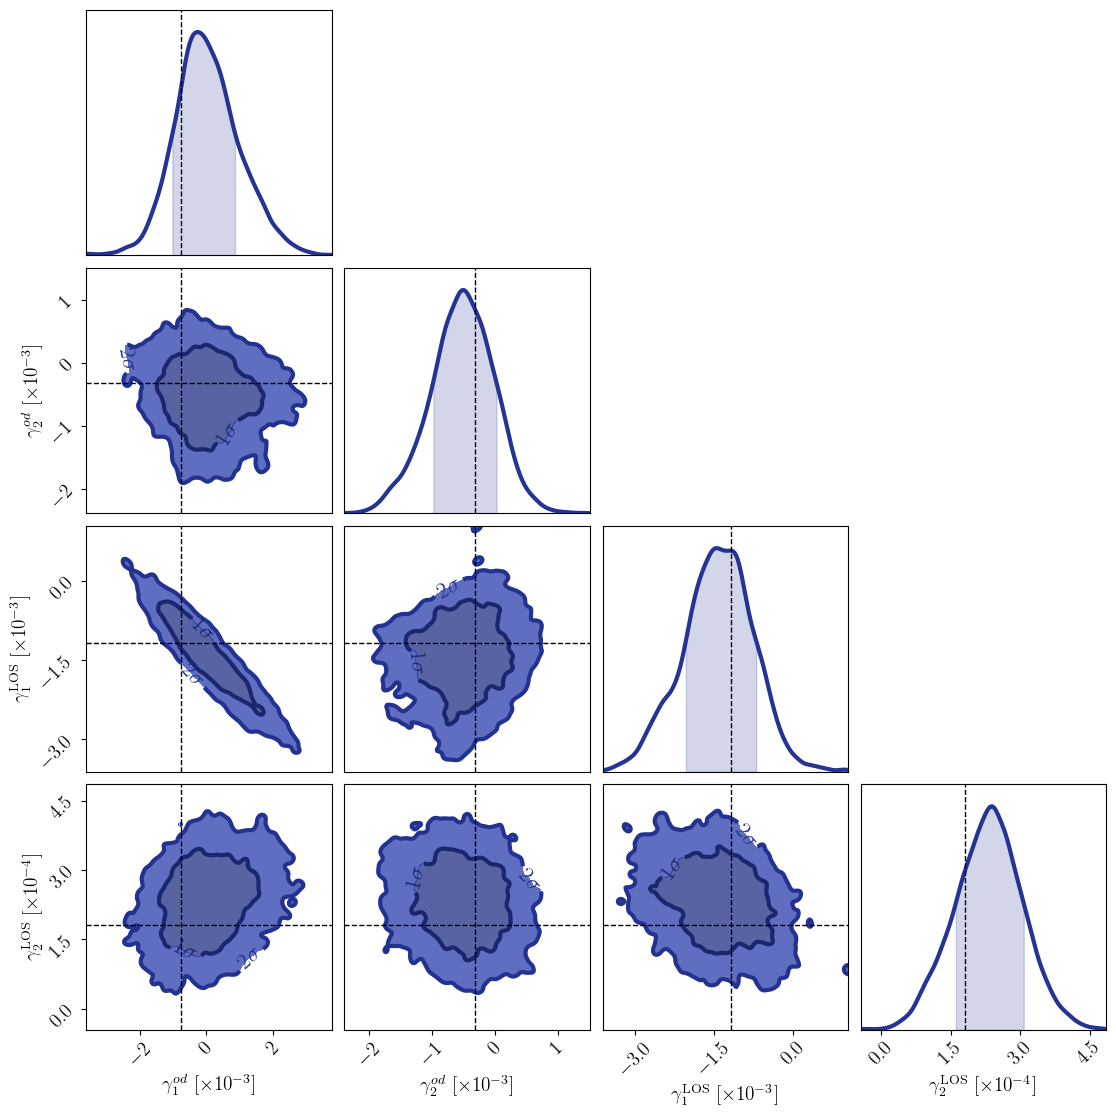

In [37]:
n_walkers = len(param_mcmc_sur)*walker_ratio

c = ChainConsumer()

c.add_chain(samples_mcmc_sur[:,0:4], walkers = n_walkers, parameters = labels_sur[0:4])

c.configure(flip = False, summary = False, 
            spacing = 1.0, max_ticks = 4,
            colors = cool[2], shade = True, shade_gradient = 0.4, 
            bar_shade = True, linewidths= [3.0],
            tick_font_size=14, label_font_size=14, 
            usetex = True, serif = True,
            contour_labels = 'sigma', contour_label_font_size = 16)

fig = c.plotter.plot(truth=expected_values_sur[0:4], figsize = (12,12))

fig.patch.set_facecolor('white')

plt.savefig(outpath + job_name + '_surviving_contours.pdf', dpi=300, bbox_inches='tight')

gelman_rubin_converged = c.diagnostic.gelman_rubin()

print(gelman_rubin_converged)

[Back to contents](#contents)